# Loading yFinance data (Daily close prices of tech stocks in the S&P500)

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm

def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

def get_stock_data(ticker, start, end):
    stock = yf.download(ticker, start=start, end=end)
    stock = flatten_columns(stock)
    stock['Returns'] = stock['Close'].pct_change()
    return stock

def calculate_momentum(df):
    df['mom1m'] = df['Close'].pct_change(periods=21)
    df['mom12m'] = df['Close'].pct_change(periods=252)
    df['mom36m'] = df['Close'].pct_change(periods=756)
    df['chmom'] = df['mom12m'] - df['mom1m']
    return df

def calculate_industry_momentum(ticker, df, industry_returns):
    df['indmom'] = industry_returns.pct_change(periods=252)
    return df

def calculate_recent_max_return(df):
    df['maxret'] = df['Returns'].rolling(window=21).max()
    return df

def calculate_liquidity_measures(df):
    df['turn'] = df['Volume'] / df['Shares Outstanding'] if 'Shares Outstanding' in df.columns else np.nan
    df['SD_turn'] = df['turn'].rolling(window=21).std()
    df['mvel1'] = np.log(df['Close'] * df['Volume'])
    df['dolvol'] = df['Close'] * df['Volume']
    df['ill'] = (df['Returns'].abs() / df['dolvol']).rolling(21).mean()
    df['zerotrade'] = (df['Volume'] == 0).rolling(21).sum()
    df['baspread'] = (df['High'] - df['Low']) / df['Close']
    return df

def calculate_risk_measures(df, sp500_returns):
    df = df.dropna(subset=['Returns'])
    sp500_returns_aligned = sp500_returns.loc[df.index].dropna()
    df = df.loc[sp500_returns_aligned.index]
    
    X = sm.add_constant(sp500_returns_aligned)
    model = sm.OLS(df['Returns'], X).fit()
    
    # FutureWarning: using positional access; here we extract the beta coefficient safely
    df['beta'] = model.params.iloc[1]
    df['idiovol'] = model.resid.rolling(window=21).std()
    df['betasq'] = df['beta'] ** 2
    return df

def calculate_fundamentals(ticker, df):
    # Get fundamental data from the income statement
    stock = yf.Ticker(ticker)
    fundamentals = stock.financials
    # Print keys for debugging
    print("Available fundamentals keys for", ticker, ":", fundamentals.index.tolist())
    
    # Try to determine the equity component from fundamentals first
    equity_key = None
    for key in ['Total Equity', 'Total Stockholder Equity', 'Stockholders Equity']:
        if key in fundamentals.index:
            # Use the most recent (first) reported value
            equity_key = fundamentals.loc[key].iloc[0]
            break
    # If not found, try the balance sheet (which often holds equity information)
    if equity_key is None:
        bs = stock.balance_sheet
        for key in ['Total Stockholder Equity', 'Stockholders Equity']:
            if key in bs.index:
                equity_key = bs.loc[key].iloc[0]
                break
    if equity_key is None or pd.isna(equity_key):
        raise KeyError(f"No recognized equity key found for ticker {ticker}. Check the available keys in financials and balance_sheet.")
    
    # Get Net Income and Total Revenue from fundamentals (use the most recent value)
    if 'Net Income' in fundamentals.index:
        net_income = fundamentals.loc['Net Income'].iloc[0]
    else:
        raise KeyError("Net Income not found in fundamentals.")
        
    if 'Total Revenue' in fundamentals.index:
        total_rev = fundamentals.loc['Total Revenue'].iloc[0]
    else:
        raise KeyError("Total Revenue not found in fundamentals.")
    
    # Calculate ratios using the most recent values
    df['ep'] = net_income / equity_key
    df['sp'] = total_rev / equity_key
    
    # For asset growth, we attempt to get Total Assets from the balance sheet if available
    bs = stock.balance_sheet
    total_assets = np.nan
    if 'Total Assets' in bs.index:
        total_assets = bs.loc['Total Assets'].iloc[0]
    df['agr'] = np.nan  # Without a time series of assets, growth rate is set to NaN
    
    # Similarly, setting nincr (net income increase count) to NaN when using a single snapshot
    df['nincr'] = np.nan
    return df

# Settings
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "META", "GOOGL", "GOOG", "AVGO", 
           "ADBE", "CRM", "CSCO", "ACN", "ORCL", "AMD", "QCOM", "INTC", "TXN", 
           "INTU", "NOW", "AMAT", "PYPL", "ADI", "CDNS", "SNPS", "KLAC", "FTNT",
           "ANET", "PANW", "ADSK", "MCHP", "CTSH", "ON", "MPWR", "EPAM", "KEYS",
           "ANSS", "ZBRA", "FSLR", "JNPR", "HPQ", "NTAP", "FFIV", "AKAM", "SWKS",
           "GEN", "VRSN"]

start_date = "1986-01-01"
end_date = "2023-12-31"

# Get S&P 500 data for beta calculations
sp500 = get_stock_data("^GSPC", start_date, end_date)
print("S&P 500 Data Columns:", sp500.columns.tolist())
sp500_returns = sp500['Close'].pct_change()

data_list = []
for ticker in tickers:
    data = get_stock_data(ticker, start_date, end_date)
    data = calculate_momentum(data)
    data = calculate_recent_max_return(data)
    data = calculate_liquidity_measures(data)
    data = calculate_risk_measures(data, sp500_returns)
    
    try:
        data = calculate_fundamentals(ticker, data)
    except KeyError as e:
        # If fundamentals for this ticker are unavailable, set the ratios to NaN
        print(e)
        data['ep'] = np.nan
        data['sp'] = np.nan
        data['agr'] = np.nan
        data['nincr'] = np.nan
        
    data['Ticker'] = ticker
    data_list.append(data)

final_df = pd.concat(data_list)

In [3]:
# Remove all dates before 1990
final_df = final_df[final_df.index >= '1990-01-01']
final_df.head()

Price,Close,High,Low,Open,Volume,Returns,mom1m,mom12m,mom36m,chmom,...,zerotrade,baspread,beta,idiovol,betasq,ep,sp,agr,nincr,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.262129,0.263889,0.246296,0.248056,183198400,0.056738,-0.158192,-0.068339,0.742871,0.089853,...,0.0,0.067113,1.181489,0.032978,1.395915,1.645935,6.866286,NaN,NaN,AAPL
1990-01-03,0.263888,0.267408,0.263888,0.267408,207995200,0.006710,-0.147728,-0.098376,0.715361,0.049352,...,0.0,0.013336,1.181489,0.033132,1.395915,1.645935,6.866286,NaN,NaN,AAPL
1990-01-04,0.264769,0.272685,0.262129,0.269167,221513600,0.003336,-0.168507,-0.100720,0.721084,0.067787,...,0.0,0.039867,1.181489,0.032603,1.395915,1.645935,6.866286,NaN,NaN,AAPL
1990-01-05,0.265648,0.269167,0.260370,0.265648,123312000,0.003322,-0.161111,-0.105670,0.703018,0.055440,...,0.0,0.033113,1.181489,0.032958,1.395915,1.645935,6.866286,NaN,NaN,AAPL
1990-01-08,0.267408,0.267408,0.260370,0.263889,101572800,0.006622,-0.111109,-0.107601,0.709586,0.003508,...,0.0,0.026317,1.181489,0.031816,1.395915,1.645935,6.866286,NaN,NaN,AAPL


In [4]:
# Sum up the number of NA values for each column
na_counts = final_df.isna().sum()

# Print the number of NA values for each column
print("Number of NA values for each column:")
print(na_counts)

Number of NA values for each column:
Price
Close             0
High              0
Low               0
Open              0
Volume            0
Returns           0
mom1m           620
mom12m         7901
mom36m        24137
chmom          7901
maxret          620
turn         296207
SD_turn      296207
mvel1             0
dolvol            0
ill            1383
zerotrade       589
baspread          0
beta              0
idiovol         620
betasq            0
ep             8565
sp             8565
agr          296207
nincr        296207
Ticker            0
dtype: int64


In [ ]:
# Drop the specified columns due to NA values
columns_to_drop = ['turn', 'SD_turn', 'agr', 'nincr', 'ep', 'sp']
final_df = final_df.drop(columns=columns_to_drop)

# Impute the remaining columns with NA values using the mean of each Ticker group
final_df = final_df.groupby('Ticker').apply(lambda group: group.fillna(group.mean())).reset_index()

# Save the DataFrame to a CSV file in the data folder
final_df.to_csv("../data/all_stocks_factors.csv", index=False)

final_df.shape

# Merging company fundamentals and FRED data with stock price data

In [5]:
import pandas as pd

# Load CSV files
# Stock daily data csv
df_factors = pd.read_csv("../data/all_stocks_factors.csv")

# Stock fundamentals data csv
df_funda = pd.read_csv("../data/stocks_fundamentals.csv")

# Stock macro data csv
df_macro= pd.read_csv("../data/micro_data.csv")
df_macro.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Treasury Yield data csv
df_treasuryyield = pd.read_csv("../data/DGS3MO.csv")
df_treasuryyield['observation_date'] = pd.to_datetime(df_treasuryyield['observation_date'])
# Interpolate the treasury yield
df_treasuryyield['DGS3MO'] = df_treasuryyield['DGS3MO'].interpolate(method='cubic')
# Convert the treasury yield to a daily yield (Assuming 252 trading days in a year)
df_treasuryyield['DGS3MO'] = (1+df_treasuryyield['DGS3MO']/100)**(1/252)-1
df_treasuryyield.rename(columns={'DGS3MO': 'treasury_yield'},inplace=True)

# Convert Date in df_factors to YYYY-MM-DD
df_factors['Date'] = pd.to_datetime(df_factors['Date'])
df_factors['YearMonth'] = df_factors['Date'].dt.to_period('M')

# Convert public_date in df_macro to YYYY-MM-DD
df_macro['Date'] = pd.to_datetime(df_macro['Date'])

# Convert public_date in df_funda to YYYY-MM-DD
df_funda['public_date'] = pd.to_datetime(df_funda['public_date'].astype(str))

# Convert public_date in df_macro to YYYY-MM-DD
df_macro['Date'] = pd.to_datetime(df_macro['Date'])

df_funda['YearMonth'] = df_funda['public_date'].dt.to_period('M')+1
df_funda.rename(columns={'TICKER': 'Ticker'}, inplace=True)

In [6]:
# Merge the DataFrames
merged_df = df_factors.merge(df_funda, on=['Ticker', 'YearMonth'], how='left')
merged_df_treasury = merged_df.merge(df_treasuryyield, left_on='Date', right_on='observation_date', how='left')
final_merged_df = merged_df_treasury.merge(df_macro, on='Date', how='left')

# # Compute the risk premium
final_merged_df['risk_premium'] = final_merged_df['Returns'] - final_merged_df['treasury_yield']
# Drop specified columns
final_merged_df = final_merged_df.drop(columns=['treasury_yield', 'Close', 'High', 'Low', 'Open','Returns', 'Volume', 'public_date', 'YearMonth', 'observation_date',"permno","adate","qdate"])
# Move 'risk_premium' to the first column
cols = ['risk_premium'] + [col for col in final_merged_df if col != 'risk_premium']
final_merged_df = final_merged_df[cols]

final_merged_df.head()

,risk_premium,Ticker,Date,mom1m,mom12m,mom36m,chmom,maxret,mvel1,dolvol,...,pay_turn,sale_invcap,sale_equity,sale_nwc,ptb,PEG_trailing,divyield,TBL,TMS,DFY
0,0.056438,AAPL,1990-01-02,-0.158192,-0.068340,0.742870,0.089853,0.056737,17.687163,4.802168e+07,...,7.965,3.556,3.556,3.776,2.387,0.215,1.25%,7.58,0.36,0.95
1,0.006410,AAPL,1990-01-03,-0.147728,-0.098376,0.715361,0.049352,0.056737,17.820797,5.488755e+07,...,7.965,3.556,3.556,3.776,2.387,0.215,1.25%,7.63,0.36,0.95
2,0.003036,AAPL,1990-01-04,-0.168508,-0.100720,0.721083,0.067787,0.056737,17.887097,5.864991e+07,...,7.965,3.556,3.556,3.776,2.387,0.215,1.25%,7.59,0.39,0.95
3,0.003025,AAPL,1990-01-05,-0.161110,-0.105670,0.703019,0.055440,0.056737,17.304647,3.275766e+07,...,7.965,3.556,3.556,3.776,2.387,0.215,1.25%,7.54,0.45,0.95
4,0.006324,AAPL,1990-01-08,-0.111109,-0.107600,0.709587,0.003509,0.056737,17.117305,2.716134e+07,...,7.965,3.556,3.556,3.776,2.387,0.215,1.25%,7.54,0.48,0.95


In [7]:
# Data Cleaning
# Print all columns with NA values
nan_counts = final_merged_df.isnull().sum()
print(nan_counts)

columns_with_na = nan_counts[nan_counts > 0]
columns_over_threshold = nan_counts[nan_counts > 50000]
print("\nColumns with more than 50,000 NaN values:", len(columns_over_threshold))
print(columns_over_threshold)

# Drop columns with more than 50,000 NaN values
final_merged_df = final_merged_df.drop(columns=columns_over_threshold.index)

final_merged_df.head()

risk_premium         0
Ticker               0
Date                 0
mom1m                0
mom12m               0
                 ...  
PEG_trailing    129625
divyield        207924
TBL                  0
TMS                  0
DFY                  0
Length: 84, dtype: int64

Columns with more than 50,000 NaN values: 12
pe_op_dil           74637
dpr                 64410
efftax              68059
int_debt           113920
int_totdebt        107796
short_debt          93507
intcov              98649
intcov_ratio        98649
cash_conversion     96710
inv_turn           113271
PEG_trailing       129625
divyield           207924
dtype: int64


,risk_premium,Ticker,Date,mom1m,mom12m,mom36m,chmom,maxret,mvel1,dolvol,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,ptb,TBL,TMS,DFY
0,0.056438,AAPL,1990-01-02,-0.158192,-0.068340,0.742870,0.089853,0.056737,17.687163,4.802168e+07,...,2.19,7.382,7.965,3.556,3.556,3.776,2.387,7.58,0.36,0.95
1,0.006410,AAPL,1990-01-03,-0.147728,-0.098376,0.715361,0.049352,0.056737,17.820797,5.488755e+07,...,2.19,7.382,7.965,3.556,3.556,3.776,2.387,7.63,0.36,0.95
2,0.003036,AAPL,1990-01-04,-0.168508,-0.100720,0.721083,0.067787,0.056737,17.887097,5.864991e+07,...,2.19,7.382,7.965,3.556,3.556,3.776,2.387,7.59,0.39,0.95
3,0.003025,AAPL,1990-01-05,-0.161110,-0.105670,0.703019,0.055440,0.056737,17.304647,3.275766e+07,...,2.19,7.382,7.965,3.556,3.556,3.776,2.387,7.54,0.45,0.95
4,0.006324,AAPL,1990-01-08,-0.111109,-0.107600,0.709587,0.003509,0.056737,17.117305,2.716134e+07,...,2.19,7.382,7.965,3.556,3.556,3.776,2.387,7.54,0.48,0.95


In [8]:
nan_counts = final_merged_df.isnull().sum()
columns_with_na = nan_counts[nan_counts > 0]
columns_with_na

CAPEI             43226
bm                47022
evm               36916
pe_op_basic       37615
pe_exi            37484
pe_inc            37484
ps                36916
pcf               37608
npm               36916
opmbd             36916
opmad             36916
gpm               36916
ptpm              36916
cfm               36916
roa               37482
roe               48863
roce              40989
aftret_eq         37482
aftret_invcapx    40043
aftret_equity     37482
pretret_noa       37461
pretret_earnat    37461
GProf             36916
equity_invcap     37002
debt_invcap       39840
totdebt_invcap    39840
capital_ratio     39754
cash_lt           37476
invt_act          41223
rect_act          38238
debt_at           39754
debt_ebitda       39754
curr_debt         37476
lt_debt           39754
profit_lct        36916
ocf_lct           37608
cash_debt         41324
fcf_ocf           46667
lt_ppent          37476
dltt_be           49686
debt_assets       37476
debt_capital    

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Copy the dataframe to avoid modifying the original
df = final_merged_df.copy()

# 1. Forward/Backward Fill
stable_valuation_metrics = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'ptb']
df[stable_valuation_metrics] = df[stable_valuation_metrics].fillna(method='ffill').fillna(method='bfill')

# 2. Linear Interpolation
profitability_ratios = ['npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'aftret_eq', 
                        'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf']
df[profitability_ratios] = df[profitability_ratios].interpolate(method='linear')

# 3. KNN Imputation
debt_capital_ratios = ['equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'debt_at', 
                       'debt_ebitda', 'curr_debt', 'lt_debt', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio']
knn_imputer = KNNImputer(n_neighbors=3)
df[debt_capital_ratios] = pd.DataFrame(knn_imputer.fit_transform(df[debt_capital_ratios]), 
                                       columns=debt_capital_ratios, index=df.index)

# 4. Spline Interpolation
cyclical_metrics = ['cash_lt', 'invt_act', 'rect_act', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent']
df[cyclical_metrics] = df[cyclical_metrics].interpolate(method='spline', order=3)

# 5. Exponential Weighted Moving Average (EWMA)
volatile_ratios = ['cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'rect_turn', 'pay_turn', 
                   'sale_invcap', 'sale_equity', 'sale_nwc']
df[volatile_ratios] = df[volatile_ratios].apply(lambda x: x.ewm(span=5, adjust=False).mean())

# 6. Final cleanup to ensure no missing values
df = df.fillna(method='ffill').fillna(method='bfill')

# Check for any remaining NAs
remaining_nas = df.isna().sum()
print("Remaining NAs after imputation:")
print(remaining_nas[remaining_nas > 0])

# Assign the imputed dataframe back to final_merged_df
final_merged_df = df

In [10]:
print(final_merged_df.isna().sum())

print(final_merged_df.head())

risk_premium    0
Ticker          0
Date            0
mom1m           0
mom12m          0
               ..
sale_nwc        0
ptb             0
TBL             0
TMS             0
DFY             0
Length: 72, dtype: int64
   risk_premium Ticker        Date     mom1m    mom12m    mom36m     chmom  \
0      0.056438   AAPL  1990-01-02 -0.158192 -0.068340  0.742870  0.089853   
1      0.006410   AAPL  1990-01-03 -0.147728 -0.098376  0.715361  0.049352   
2      0.003036   AAPL  1990-01-04 -0.168508 -0.100720  0.721083  0.067787   
3      0.003025   AAPL  1990-01-05 -0.161110 -0.105670  0.703019  0.055440   
4      0.006324   AAPL  1990-01-08 -0.111109 -0.107600  0.709587  0.003509   

     maxret      mvel1        dolvol  ...  at_turn  rect_turn  pay_turn  \
0  0.056737  17.687163  4.802168e+07  ...     2.19      7.382     7.965   
1  0.056737  17.820797  5.488755e+07  ...     2.19      7.382     7.965   
2  0.056737  17.887097  5.864991e+07  ...     2.19      7.382     7.965   
3  0.056

In [11]:
final_merged_df

,risk_premium,Ticker,Date,mom1m,mom12m,mom36m,chmom,maxret,mvel1,dolvol,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,ptb,TBL,TMS,DFY
0,0.056438,AAPL,1990-01-02,-0.158192,-0.068340,0.742870,0.089853,0.056737,17.687163,4.802168e+07,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.58,0.36,0.95
1,0.006410,AAPL,1990-01-03,-0.147728,-0.098376,0.715361,0.049352,0.056737,17.820797,5.488755e+07,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.63,0.36,0.95
2,0.003036,AAPL,1990-01-04,-0.168508,-0.100720,0.721083,0.067787,0.056737,17.887097,5.864991e+07,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.59,0.39,0.95
3,0.003025,AAPL,1990-01-05,-0.161110,-0.105670,0.703019,0.055440,0.056737,17.304647,3.275766e+07,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.54,0.45,0.95
4,0.006324,AAPL,1990-01-08,-0.111109,-0.107600,0.709587,0.003509,0.056737,17.117305,2.716134e+07,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.54,0.48,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296202,0.015243,ZBRA,2023-12-22,0.192819,0.074031,-0.283312,-0.118787,0.113448,17.924082,6.085972e+07,...,0.682082,7.213,4.452944,1.011167,1.747312,358.917,3.941,5.24,-1.34,0.90
296203,0.022394,ZBRA,2023-12-26,0.203477,0.113086,-0.274924,-0.090391,0.113448,17.919970,6.061000e+07,...,0.682055,7.213,4.452962,1.011112,1.747208,358.917,3.941,5.25,-1.36,0.90
296204,0.000842,ZBRA,2023-12-27,0.191318,0.111071,-0.273740,-0.080247,0.113448,18.146708,7.603531e+07,...,0.682037,7.213,4.452975,1.011074,1.747139,358.917,3.941,5.24,-1.45,0.90
296205,-0.001806,ZBRA,2023-12-28,0.177263,0.097012,-0.269415,-0.080251,0.113448,17.793141,5.339037e+07,...,0.682024,7.213,4.452983,1.011050,1.747092,358.917,3.941,5.25,-1.41,0.90


In [ ]:
# Export the final merged DataFrame with Tickers to a CSV file
final_merged_df.to_csv("../data/final_merged_df_with_tickers.csv", index=False)

In [ ]:
final_merged_df.drop("Ticker", axis=1, inplace=True)
final_merged_df
final_merged_df.to_csv("../data/final_merged_df.csv", index=False)

In [12]:
final_merged_df

,risk_premium,Date,mom1m,mom12m,mom36m,chmom,maxret,mvel1,dolvol,ill,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,ptb,TBL,TMS,DFY
0,0.056438,1990-01-02,-0.158192,-0.068340,0.742870,0.089853,0.056737,17.687163,4.802168e+07,3.649884e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.58,0.36,0.95
1,0.006410,1990-01-03,-0.147728,-0.098376,0.715361,0.049352,0.056737,17.820797,5.488755e+07,3.648693e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.63,0.36,0.95
2,0.003036,1990-01-04,-0.168508,-0.100720,0.721083,0.067787,0.056737,17.887097,5.864991e+07,3.239410e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.59,0.39,0.95
3,0.003025,1990-01-05,-0.161110,-0.105670,0.703019,0.055440,0.056737,17.304647,3.275766e+07,3.219482e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.54,0.45,0.95
4,0.006324,1990-01-08,-0.111109,-0.107600,0.709587,0.003509,0.056737,17.117305,2.716134e+07,3.099298e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.54,0.48,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296202,0.015243,2023-12-22,0.192819,0.074031,-0.283312,-0.118787,0.113448,17.924082,6.085972e+07,1.623961e-10,...,0.682082,7.213,4.452944,1.011167,1.747312,358.917,3.941,5.24,-1.34,0.90
296203,0.022394,2023-12-26,0.203477,0.113086,-0.274924,-0.090391,0.113448,17.919970,6.061000e+07,1.657183e-10,...,0.682055,7.213,4.452962,1.011112,1.747208,358.917,3.941,5.25,-1.36,0.90
296204,0.000842,2023-12-27,0.191318,0.111071,-0.273740,-0.080247,0.113448,18.146708,7.603531e+07,1.619918e-10,...,0.682037,7.213,4.452975,1.011074,1.747139,358.917,3.941,5.24,-1.45,0.90
296205,-0.001806,2023-12-28,0.177263,0.097012,-0.269415,-0.080251,0.113448,17.793141,5.339037e+07,1.584680e-10,...,0.682024,7.213,4.452983,1.011050,1.747092,358.917,3.941,5.25,-1.41,0.90


# Converting from Daily to Weekly Close

In [35]:
import pandas as pd

# Load dataset
df = pd.read_csv('../data/final_merged_df_with_tickers.csv')
ticker_count_new = df['Ticker'].nunique()

# Convert to datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Resample and count tickers
weekly_df = (df.groupby('Ticker', group_keys=False)
             .resample('W-FRI')
             .last()
             .reset_index())

weekly_df
weekly_df.to_csv("../data/weekly_df_with_tickers.csv", index=False)

In [36]:
weekly_df.drop("Ticker", axis=1, inplace=True)
weekly_df.to_csv("../data/weekly_df.csv", index=False)
weekly_df

,Date,risk_premium,mom1m,mom12m,mom36m,chmom,maxret,mvel1,dolvol,ill,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,ptb,TBL,TMS,DFY
0,1990-01-05,0.003025,-0.161110,-0.105670,0.703019,0.055440,0.056737,17.304647,3.275766e+07,3.219482e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.54,0.45,0.95
1,1990-01-12,-0.000296,-0.041667,-0.194478,0.448650,-0.152811,0.056737,17.546802,4.173297e+07,3.638351e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.50,0.60,0.95
2,1990-01-19,0.057609,-0.021427,-0.156428,0.395225,-0.135001,0.057915,17.972879,6.390314e+07,4.438585e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.74,0.52,0.95
3,1990-01-26,-0.040597,-0.067614,-0.121020,0.207917,-0.053406,0.057915,17.547722,4.177137e+07,4.824237e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.68,0.81,0.95
4,1990-02-02,0.018281,-0.089701,-0.118817,0.298334,-0.029116,0.057915,17.167320,2.855436e+07,4.909231e-10,...,2.190000,7.382,7.965000,3.556000,3.556000,3.776,2.303,7.81,0.69,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61383,2023-12-01,0.017682,0.218344,-0.107518,-0.362560,-0.325862,0.064409,18.432767,1.012159e+08,1.847212e-10,...,0.718000,7.213,4.428333,1.084333,1.883667,358.917,3.941,5.23,-1.01,0.90
61384,2023-12-08,0.012224,0.143819,-0.064980,-0.368349,-0.208799,0.064409,17.809782,5.428629e+07,1.622876e-10,...,0.686741,7.213,4.449752,1.020657,1.764997,358.917,3.941,5.24,-1.01,0.90
61385,2023-12-15,-0.007485,0.245299,0.033193,-0.295415,-0.212106,0.113448,19.439292,2.769345e+08,1.483629e-10,...,0.682624,7.213,4.452572,1.012272,1.749370,358.917,3.941,5.24,-1.33,0.90
61386,2023-12-22,0.015243,0.192819,0.074031,-0.283312,-0.118787,0.113448,17.924082,6.085972e+07,1.623961e-10,...,0.682082,7.213,4.452944,1.011167,1.747312,358.917,3.941,5.24,-1.34,0.90


# Exploratory Data Analysis

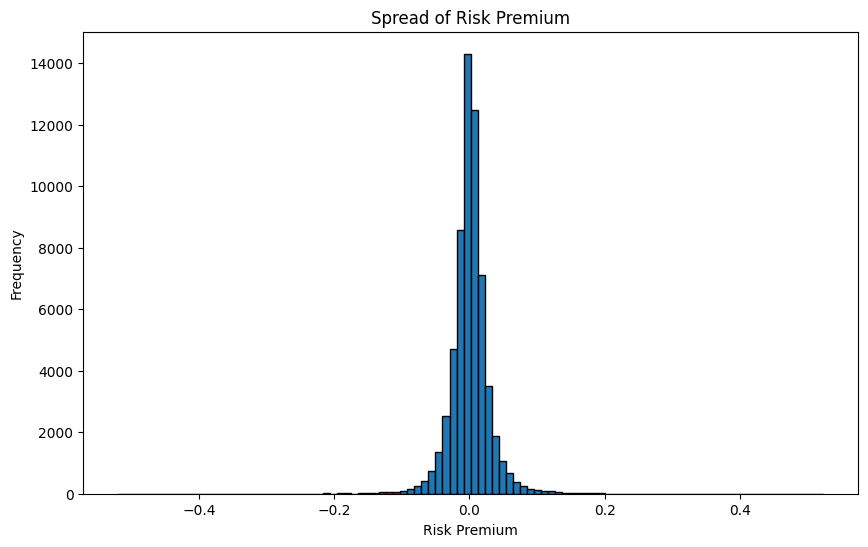

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(weekly_df['risk_premium'].dropna(), bins=100, edgecolor='k')
plt.title('Spread of Risk Premium')
plt.xlabel('Risk Premium')
plt.ylabel('Frequency')
plt.show()

# Visualisations for Presentation

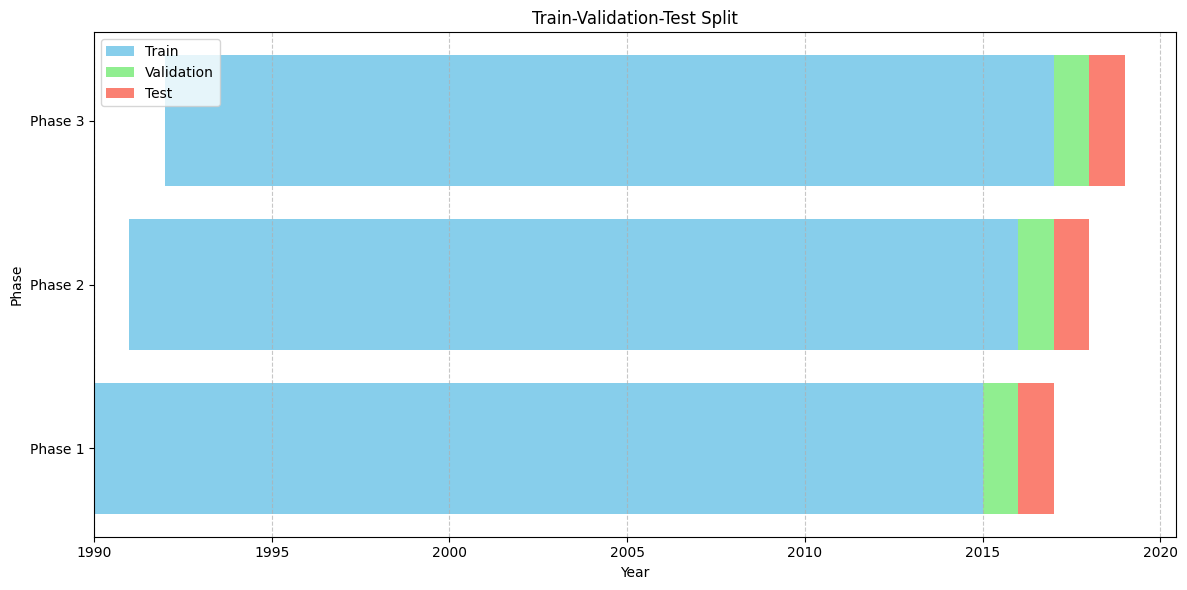

In [ ]:
import matplotlib.pyplot as plt

# Define the years for each phase
train_years_phase_1 = [
    list(range(1990, 2015)),  # Train for Test Year 2016
    list(range(1991, 2016)),  # Train for Test Year 2017
    list(range(1992, 2017)),  # Train for Test Year 2018
]
validation_years_phase_1 = [2015, 2016, 2017]  # Validation years
test_years_phase_1 = [2016, 2017, 2018]       # Test years

# Plot the timeline using horizontal bars
plt.figure(figsize=(12, 6))

for i, (train_years, val_year, test_year) in enumerate(zip(train_years_phase_1, validation_years_phase_1, test_years_phase_1)):
    # Plot training years as a horizontal bar
    plt.barh(i + 1, len(train_years), left=min(train_years), color='skyblue', label='Train' if i == 0 else "")
    # Plot validation year as a horizontal bar
    plt.barh(i + 1, 1, left=val_year, color='lightgreen', label='Validation' if i == 0 else "")
    # Plot test year as a horizontal bar
    plt.barh(i + 1, 1, left=test_year, color='salmon', label='Test' if i == 0 else "")

# Add labels and legend
plt.yticks(range(1, len(train_years_phase_1) + 1), [f"Phase {i + 1}" for i in range(len(train_years_phase_1))])
plt.xlabel("Year")
plt.ylabel("Phase")
plt.title("Train-Validation-Test Split")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [1]:
# Note that these files were saved differently in the respective ML notebooks. However for the ease of viewing the repo, we have renamed those files.
# Thus, if you run the respective notebooks, you will have to rename the files:
import pandas as pd

# Renamed from rolling_window_results_with_validation.csv to r2_scores_RF.csv
df1 = pd.read_csv('r2_scores_RF.csv')
df1 = df1[df1['val_end'] != "2016-12-31"].reset_index(drop=True)

# Renamed from NN1_performance_metrics.csv to r2_scores_NN2.csv
df2 = pd.read_csv('r2_scores_NN2.csv')
df2 = df2[df2['Year'] != 2016].reset_index(drop=True)

# Renamed from NN2_performance_metrics.csv to r2_scores_NN3.csv
df3 = pd.read_csv('r2_scores_NN3.csv')
df3 = df3[df3['Year'] != 2016].reset_index(drop=True)

df4 = pd.read_csv('r2_scores_linear.csv')
df4 = df4[df4['Year'] != 2016].reset_index(drop=True)

df4 = df4.iloc[:, :3]
df1 = df1.iloc[:,4 ]
df2=df2.iloc[:,1 ]
df3=df3.iloc[:,1 ]

combined_df = pd.concat([df4,df1, df2, df3], axis=1)

# 给新合并的列命名
combined_df.columns = ['Year','OLS3','OLS','RF','NN2','NN3']

# Renamed from R^2_Result_rw.csv to r2_scores_rw.csv
df_rw = pd.read_csv("r2_scores_rw.csv")
df_rw['Year'] = pd.to_datetime(df_rw['val_start']).dt.year
df_rw = df_rw[['Year', 'overall_r2']]
df_rw = df_rw.rename(columns={'overall_r2': 'RW'})
combined_df = combined_df.merge(df_rw, on='Year', how='left')

# 保存为一个新的 CSV 文件
combined_df.to_csv('combined_R2.csv', index=False)

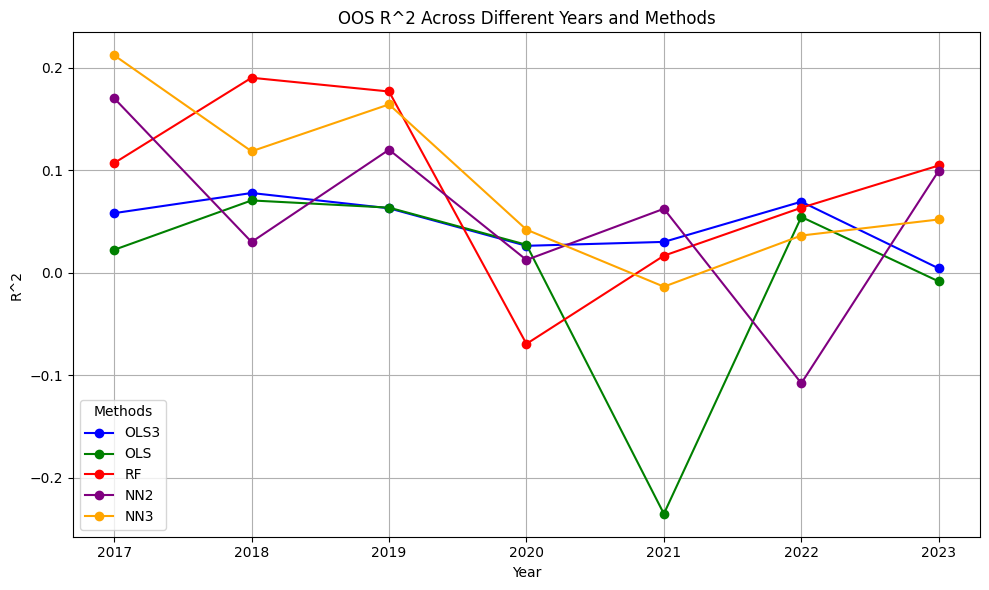

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('combined_R2.csv')

# Plotting R^2 across different years with different methods in different colors
plt.figure(figsize=(10, 6))

# Plot each method's R^2 across years
methods = ['OLS3', 'OLS', 'RF', 'NN2', 'NN3']
colors = ['blue', 'green', 'red', 'purple', 'orange']  # You can change the colors

for method, color in zip(methods, colors):
    plt.plot(df['Year'], df[method], label=method, color=color, marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('R^2')
plt.title('OOS R^2 Across Different Years and Methods')
plt.legend(title='Methods')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

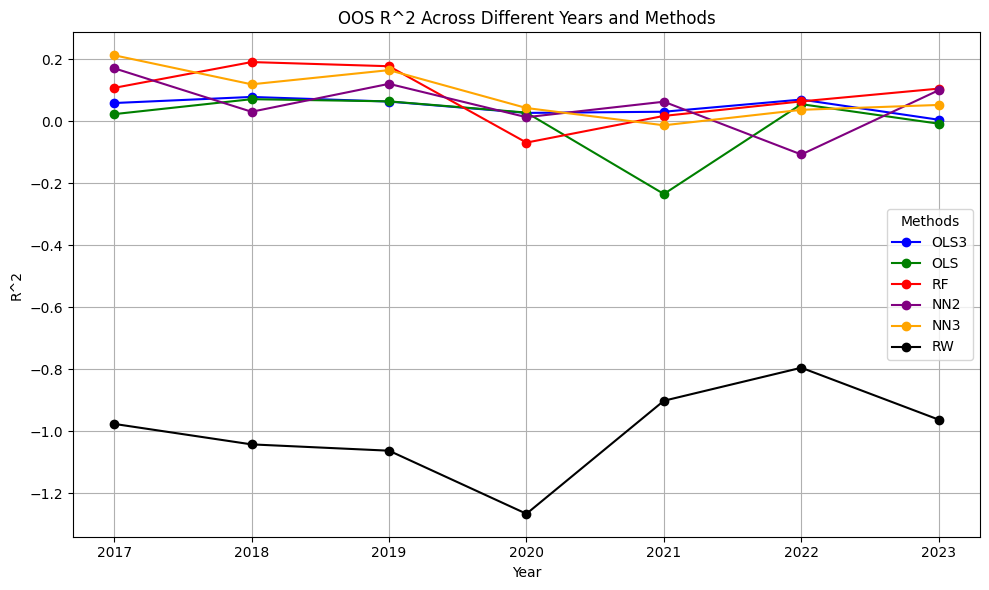

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('combined_R2.csv')

# Plotting R^2 across different years with different methods in different colors
plt.figure(figsize=(10, 6))

# Plot each method's R^2 across years
methods = ['OLS3', 'OLS', 'RF', 'NN2', 'NN3',"RW"]
colors = ['blue', 'green', 'red', 'purple', 'orange',"black"]  # You can change the colors

for method, color in zip(methods, colors):
    plt.plot(df['Year'], df[method], label=method, color=color, marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('R^2')
plt.title('OOS R^2 Across Different Years and Methods')
plt.legend(title='Methods')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()